Hi guys, here is a python notebook where we can do some analysis of our data.

In [80]:
# imports the libraries needed for the project
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tabulate import tabulate

#sets plot style
plt.style.use('seaborn-v0_8-darkgrid')

In [81]:
# time converter to datetime object for the OMNI data
tconvert = lambda x: dt.datetime.strptime(str(x), '%Y-%m-%dT%H:%M:%S.%fZ')
# reads the OMNI data into arrays
data = np.genfromtxt('OMNI20032024.csv', names=True, delimiter=',', skip_header=94, encoding='utf-8',converters={0:tconvert}, dtype=None)

time = data['TIME_AT_CENTER_OF_HOUR_yyyymmddThhmmsssssZ']
swavgB = np.array(data['1AU_IP_MAG_AVG_B_nT'], dtype = float)
swvelocity = np.array(data['1AU_IP_PLASMA_SPEED_Kms'], dtype = float)
swpressure = np.array(data['1AU_IP_FLOW_PRESSURE_nPa'], dtype = float)
swtemp = np.array(data ['1AU_IP_PLASMA_TEMP_Deg_K'], dtype = float)
swdensity = np.array(data['1AU_IP_N_ION_Per_cc'], dtype = float)
dst = np.array(data['1H_DST_nT'], dtype = float)

In [82]:
# values that need to be filtered due to null data points
arrays = [swavgB, swdensity, swvelocity, swpressure, swtemp]
# maxs of the legitimate from OMNI
filters = [80, 100, 1200, 60, 1*10**7]
# filters out non data points to be null
for array, threshold in zip(arrays, filters):
    for index, value in enumerate(array):
        if value >= threshold:
            array[index] = np.nan

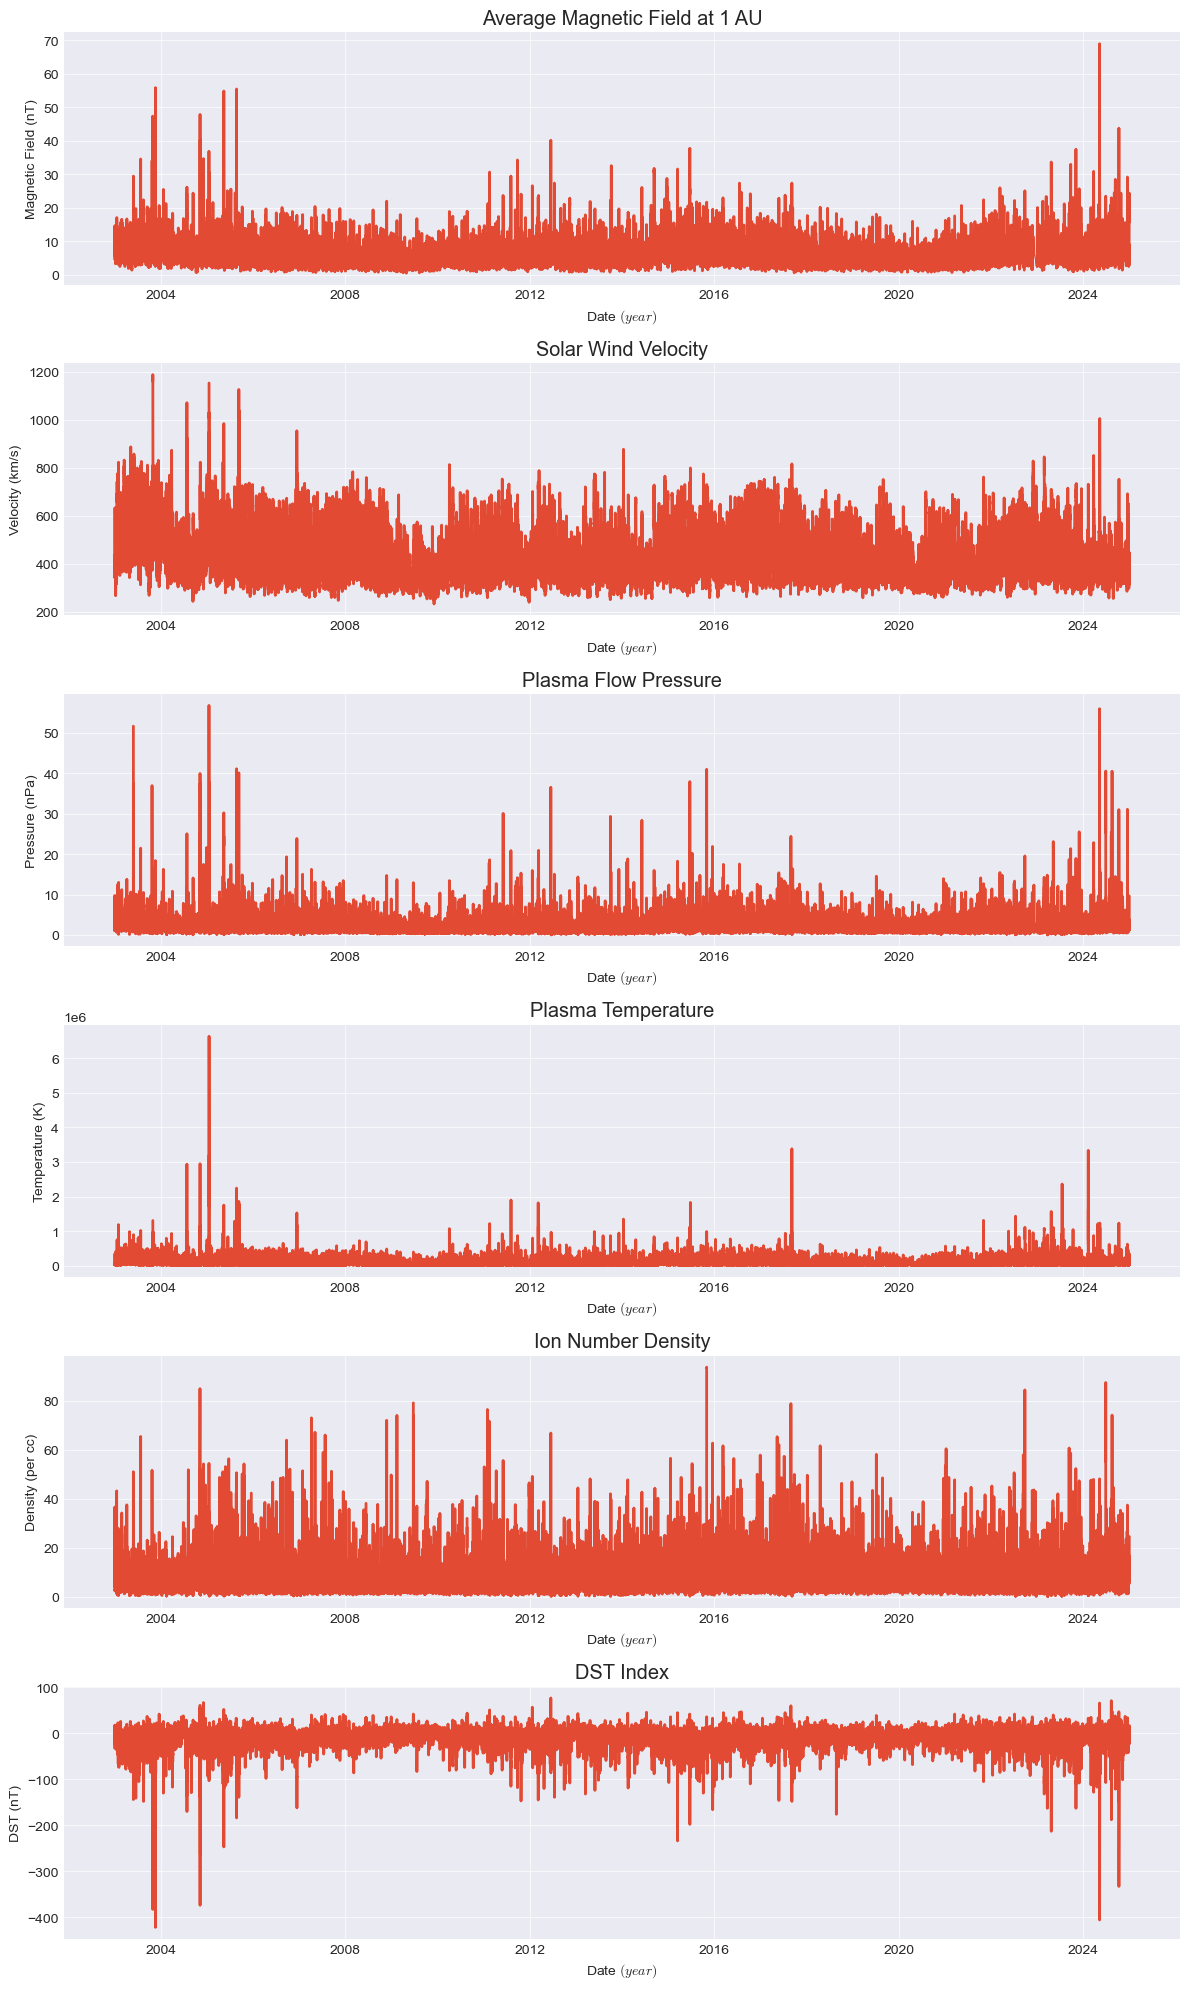

In [83]:
# correlates data to labels
data = {'Average Magnetic Field at 1 AU|Magnetic Field (nT)': (time,swavgB),
        'Solar Wind Velocity|Velocity (km/s)': (time,swvelocity),
        'Plasma Flow Pressure|Pressure (nPa)': (time,swpressure),
        'Plasma Temperature|Temperature (K)': (time,swtemp),
        'Ion Number Density|Density (per cc)': (time,swdensity),
        'DST Index|DST (nT)': (time,dst)}
fig, axes = plt.subplots(6,1, figsize = (12,20))
# for loop to add data to each plot
for ax, (label, (x, y)) in zip(axes.flat, data.items()):
    #add data to the plot
    ax.plot(x,y)
    # adds proper titles and labels
    title, space, ytext = label.partition('|')
    ax.set_title(title)   
    ax.set_xlabel(r'Date $(year)$')
    ax.set_ylabel(ytext)
fig.tight_layout()

### Identifying DST Events

Here I will identify and form a list of geomagnetic storms, identified by significant dips in the DST index below the thresholds described below.  I will categorize the storms by their "moderate", "intense" and "extreme" classes, and list both the times they occurred and the minimum value they reached on the DST data in units of nT.  I will identify the time the storm occurred by the time at which the DST index reached the minimum, such that the time listed is the time at which the listed minimum value was recorded.  

 DOI: https://doi.org/10.5194/nhess-2018-92
"Thresholds for geomagnetic storms can be chosen by common values of SYM-H and Dst, as –75 nT for moderate storms; –150 nT for intense storms, and –330 nT for extreme storms."

Text(0, 0.5, 'DST Index (nT)')

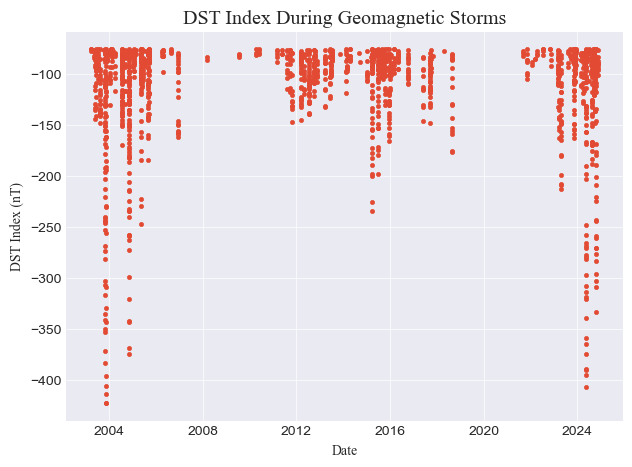

In [180]:
#first we will record all of the indices at which the DST index was below -75 nT.  Gives a complete list of indices at which a storm of at least moderate classification occurred
storm_idxs = np.where(dst < -75)[0]

#here we plot the dst data and times corresponding to these indices.
#get DST indexes and times
dst_storms = dst[storm_idxs]
storm_times = time[storm_idxs]

#set font, create plot, label axes
font = {'fontname':'Times New Roman'}
plt.scatter(storm_times, dst_storms, marker='.')
plt.title('DST Index During Geomagnetic Storms', **font)
plt.xlabel('Date', **font)
plt.ylabel('DST Index (nT)', **font)


In the cell below, we aim to identify individual geomagnetic storms and group indices that belong to the same storm.  In order to do this we will make use of our array of indices during which a storm is occurring.  

We will make the assumption that during a given geomagnetic storm, the DST index drops below -75 nT and remains below this point until the storm is over.  I expect this to be a reasonable assumption for the storms which reach lower points, such as the -150 nT mark for "intense", or the -330 nT mark for "extreme" storms, but it may not work as well for storms which bottom right around the -75 nT mark, as these might go back up briefly and come back down.  Regardless, we will start with using this method for now, treat each of these cases as distinct and separate, and advance to more complex grouping methods if necessary. 

We want to group the indices by storm, and we have defined/assumed an individual storm case to be when the DST index drops below -75 nT and remains there.  Since we have an array of the indices where the DST index is below -75 nT, we can identify a single storm case by grouping the indices which come one after another in the original array, ie. the ones which don't have any non-storm indices between them, indicating that they are part of the same stretch of DST data in which the value dropped below -75 nT and remained there, ie. a single geomagnetic storm event!

In [85]:
#here we aim to identify each individual geomagnetic storms, then group and store indices which are all part of the same storm
#The methodology is further explained above
#initialize an empty list to hold our events, and an array to group the indices for each storm case
events = []
#we initialize this with our first index included, since we know it will begin the first storm case
event = np.array([storm_idxs[0]])
#create a for loop to step through our array of storm indices
for i in range(1, len(storm_idxs)):
    #if and elif statements determine if the indice should be added to the current event grouping or not
    #if statement adds the indice to the grouping if it comes directly after the last, ie. if they are part of the same storm
    if(storm_idxs[i] - 1 == storm_idxs[i-1]):
        event = np.append(event, storm_idxs[i])
    #if the indice does not belong to the current event ie. we have moved on to the next event,
    #elif statement adds the event to the list of events, wipes the array, and starts a new event beginning with the current indice!
    elif(storm_idxs[i] - 1 != storm_idxs[i-1]):
        events.append(event)
        event = np.array([])
        event = np.append(event, storm_idxs[i])
    #else prints error message if there is an issue
    else:
        print("issue: none of the three cases have been found for i = ", i)

Text(0, 0.5, 'DST Index (nT)')

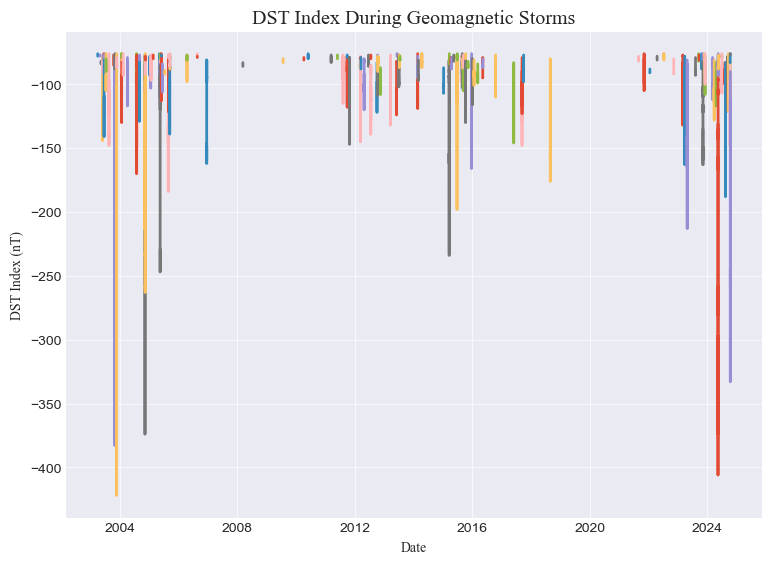

In [215]:
#create figure
plt.figure(figsize=(8,6))
#step through events, plotting each one
for event in events:
    #cast as int so they can be used for masking
    event = event.astype(int)
    #plot event
    plt.plot(time[event], dst[event])
#add title and labels
plt.title('DST Index During Geomagnetic Storms', **font)
plt.xlabel('Date', **font)
plt.ylabel('DST Index (nT)', **font)

Text(0, 0.5, 'DST Index (nT)')

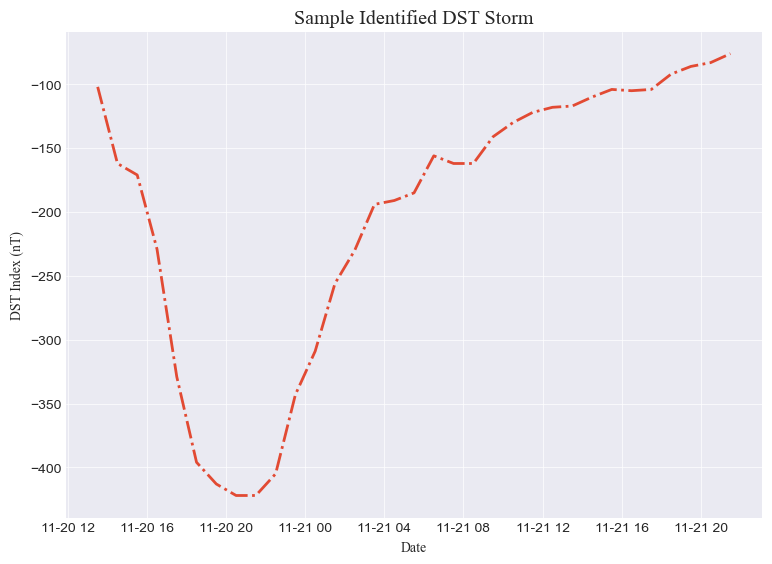

In [222]:
#plot example event
plt.figure(figsize=(8,6))
#cast as int so it can be used for masking
event0 = events[18].astype(int)
plt.plot(time[event0], dst[event0], linestyle='-.')
#add title and labels
plt.title('Sample Identified DST Storm', **font)
plt.xlabel('Date', **font)
plt.ylabel('DST Index (nT)', **font)

In [105]:
#create empty lists to store our storm times, min values, and classes
header = ['Times', 'Minimums (nT)', 'Classes']
storms = [[],[], []]
extreme = [[],[]]
intense = [[],[]]
moderate = [[],[]]
#loop through all of the storm events in order to find and record their times and min values
for event in events:
    #cast as int so they can be used for masking
    event = event.astype(int)
    #find the index during the storm which DST reaches a minimum 
    min_idx = np.argmin(dst[event])
    #use the min_idx to find the minimum DST value during the storm
    event_min = np.min(dst[event])
    #use the min_idx to find the time corresponding to the minimum DST value during the storm
    event_time = time[event[min_idx]]
    #add the times and minimum DST values to the list of storms
    storms[0].append(event_time)
    storms[1].append(event_min)
    #if statements sort the storms into our three classes, by sifting out the bigger storms
    if(event_min < -330):
        extreme[0].append(event_time)
        extreme[1].append(event_min)
        storms[2].append('extreme')
    elif(event_min < -150):
        intense[0].append(event_time)
        intense[1].append(event_min)
        storms[2].append('intense')
    else:
        moderate[0].append(event_time)
        moderate[1].append(event_min)
        storms[2].append('moderate')

#create a dict to store our list of storms and the lists of each storm class
dst_storms = {"header":header,
              "storms":storms,
              "moderate":moderate,
              "intense":intense, 
              "extreme":extreme}

In [106]:
#compare dst min value and time to the corresponding event in our extreme storm list to make sure they match
idx_min = np.argmin(dst)
minimum = dst[idx_min]
min_time = time[idx_min]
print(min_time, minimum, dst_storms['extreme'])

2003-11-20 20:30:00 -422.0 [[datetime.datetime(2003, 10, 30, 22, 30), datetime.datetime(2003, 11, 20, 20, 30), datetime.datetime(2004, 11, 8, 6, 30), datetime.datetime(2024, 5, 11, 2, 30), datetime.datetime(2024, 10, 11, 1, 30)], [-383.0, -422.0, -374.0, -406.0, -333.0]]


In [107]:
#print results for all of the storms as a vertical list
print(dst_storms['header'])
for i in range(len(dst_storms['storms'][0])):
    print(dst_storms['storms'][0][i], '|',
          dst_storms['storms'][1][i], '|',
          dst_storms['storms'][2][i])

['Times', 'Minimums (nT)', 'Classes']
2003-03-30 22:30:00 | -76.0 | moderate
2003-03-31 15:30:00 | -78.0 | moderate
2003-05-01 00:30:00 | -78.0 | moderate
2003-05-10 08:30:00 | -84.0 | moderate
2003-05-29 23:30:00 | -144.0 | moderate
2003-05-30 14:30:00 | -81.0 | moderate
2003-06-02 08:30:00 | -91.0 | moderate
2003-06-17 08:30:00 | -81.0 | moderate
2003-06-18 09:30:00 | -141.0 | moderate
2003-06-18 21:30:00 | -79.0 | moderate
2003-07-12 01:30:00 | -77.0 | moderate
2003-07-12 05:30:00 | -105.0 | moderate
2003-07-16 13:30:00 | -90.0 | moderate
2003-08-18 15:30:00 | -148.0 | moderate
2003-10-14 22:30:00 | -85.0 | moderate
2003-10-15 06:30:00 | -77.0 | moderate
2003-10-30 22:30:00 | -383.0 | extreme
2003-10-31 14:30:00 | -88.0 | moderate
2003-11-20 20:30:00 | -422.0 | extreme
2003-11-22 02:30:00 | -79.0 | moderate
2003-11-22 22:30:00 | -87.0 | moderate
2004-01-22 13:30:00 | -130.0 | moderate
2004-01-22 21:30:00 | -80.0 | moderate
2004-01-23 00:30:00 | -78.0 | moderate
2004-01-23 16:30:00 |

In [122]:
#create function which creates, prints (optional), and returns a table of the data
def table(table_data, header, trans=True, print_=True, **kwargs):
    '''
    Creates a table of data using the tabulate library
    and prints the table (optional).  Can transpose the data 
    if needed to switch rows and columns, and can take
    kwargs to pass to tabulate.

    Returns: Table of data made using the tabulate library
    '''
    #transpose the list and set to table_data, so that rows become columns
    if(trans):
        table_data = list(zip(*table_data))
    #set headers & create table, then print
    headers = header
    table = tabulate(table_data, headers, **kwargs)
    if(print_):
        print(table)
    return(table)

In [124]:
#use our table function to create a table of the data
table_data = dst_storms['storms']
headers = dst_storms['header']
#dst_table = table(table_data, headers, tablefmt='fancy_grid')
dst_table = table(table_data, headers)

Times                  Minimums (nT)  Classes
-------------------  ---------------  ---------
2003-03-30 22:30:00              -76  moderate
2003-03-31 15:30:00              -78  moderate
2003-05-01 00:30:00              -78  moderate
2003-05-10 08:30:00              -84  moderate
2003-05-29 23:30:00             -144  moderate
2003-05-30 14:30:00              -81  moderate
2003-06-02 08:30:00              -91  moderate
2003-06-17 08:30:00              -81  moderate
2003-06-18 09:30:00             -141  moderate
2003-06-18 21:30:00              -79  moderate
2003-07-12 01:30:00              -77  moderate
2003-07-12 05:30:00             -105  moderate
2003-07-16 13:30:00              -90  moderate
2003-08-18 15:30:00             -148  moderate
2003-10-14 22:30:00              -85  moderate
2003-10-15 06:30:00              -77  moderate
2003-10-30 22:30:00             -383  extreme
2003-10-31 14:30:00              -88  moderate
2003-11-20 20:30:00             -422  extreme
2003-11-22 02:3

In [168]:
#create a function to read our output to a file for ease of use
def write_to_file(filename, data, mode='w+', header=None, **args):
    '''
    Writes data into a file with given filename for easier access

    Default mode for file I/O is 'w+':
    "Opens a file for both writing and reading. 
    Overwrites the existing file if the file exists.
    If the file does not exist, creates a new file for reading and writing."

    Returns: nothing
    '''
    #open file object
    file = open(filename, mode, **args)
    print("The file '{}' has been opened in mode '{}'.".format(filename, file.mode))

    #write header to file (if one is passed), then write in data
    if(header):
        file.write(header)
    file.write(data)

    file.close()
    if(file.closed):
        print("The file '{}' has been successfully closed.".format(filename))

In [172]:
#WARNING: running this cell will as the default overwrite the contents of existing file
#write our table of DST events into our file, first create header, then write
header = ("# Climate 323: Final Project\n"
          "#This file contains a list of all of the geomagnetic storms "
          "identified from the DST dataset used for our Climate 323 final "
          "project (the dataset will be cited with our project materials). \n\n"
          "# The columns of the data are as follows:\n"
          "# Times: The times for each storm identified. These correspond to the "
          "time at which the minimum occurred.\n"
          "# Minimums: The minimum DST value reached during the storm, in units of nT.\n"
          "# Classes: The 'class' of the storm, divided into three categories based on "
          "intensity, and defined by minimum DST values below the criteria outlined here:\n"
          "#  Palacios et. al. (2018), https://doi.org/10.5194/nhess-2018-92 \n"
          "# 'Thresholds for geomagnetic storms can be chosen by common values of SYM-H "
          "and Dst, as –75 nT for moderate storms; –150 nT for intense storms, " 
          "and –330 nT for extreme storms.'\n\n")

filename = 'DST_events.txt'
write_to_file(filename, dst_table, header=header)

The file 'DST_events.txt' has been opened in mode 'w+'.
The file 'DST_events.txt' has been successfully closed.
